In [1]:
import numpy as np

import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import WDM

# Wavelet transform (exact)

In [2]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=0.5, Nf=16, N=512, calc_m0=True)

x = np.random.normal(size=wdm.N) # white noise

w = wdm.forward_transform_exact(x)

x_recovered = wdm.inverse_transform(w)

err = np.max(np.abs(x - x_recovered))

print(f"Check small error: {err}")


Check small error: 1.176836406102666e-13


# Wavelet transform (truncated)

In [3]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=0.5, 
                                                            Nf=16,
                                                            N=512, 
                                                            q=16,
                                                            calc_m0=True)

key = jax.random.key(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, shape=(wdm.N,)) # white noise

w = wdm.forward_transform_exact(x)

w_ = wdm.forward_transform_truncated(x)

assert np.allclose(w, w_, rtol=1.0e-2, atol=1.0e-2), \
    "Truncated transform did not agree with the exact transform."

In [4]:
q_vals = [1,2,4,8,10,12,14,16]

err_vals = np.zeros(len(q_vals))

for i, q in enumerate(q_vals): 
    wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=0.5, 
                                                                Nf=16,
                                                                N=512, 
                                                                q=q,
                                                                calc_m0=True)
                                                                

    w = wdm.forward_transform_truncated(x)

    x_recovered = wdm.inverse_transform(w)

    err_vals[i] = np.max(np.abs(x - x_recovered))

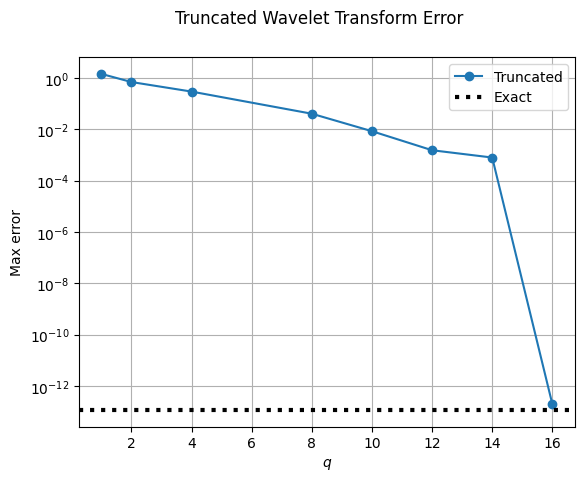

In [5]:
fig, ax = plt.subplots()
fig.suptitle("Truncated Wavelet Transform Error")

ax.plot(q_vals, err_vals, marker='o', label='Truncated')
ax.axhline(err, color='k', lw=3, linestyle=':', label='Exact')

ax.set_xlabel(r"$q$")
ax.set_ylabel(r"Max error")

ax.set_yscale('log')

ax.grid()
ax.legend(loc='upper right')

plt.show()

# Wavelet transform (short fft)

In [6]:
w = wdm.forward_transform_exact(x)

w_ = wdm.forward_transform_short_fft(x)

assert np.allclose(w, w_, rtol=1.0e-2, atol=1.0e-2), \
    "Short fft transform did not agree with the exact transform."

# Wavelet transform (fft)

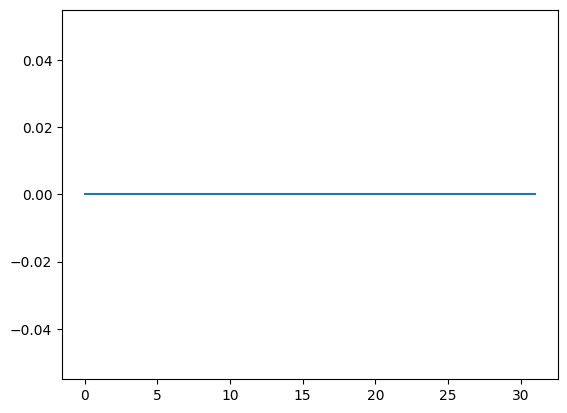

In [7]:
w = wdm.forward_transform_exact(x)

w_ = wdm.forward_transform_fft(x)

plt.plot(w_[:,1])
plt.show()